# **Text Generation: The Office Lines**

The goal of the project is to generate dialogue lines in the style of The Office TV series, conditioned on a given character.
Given a specific character as input, the models aim to produce text that resembles that character’s typical speech patterns, vocabulary, and tone, based on learned dialogue data from the series.

In [ ]:
#Importing Packages
import kagglehub
import os
import re
import random
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# **1. Understanding the dataset**

In [ ]:
path = kagglehub.dataset_download("fabriziocominetti/the-office-lines")
print("Path to dataset files:", path)

100%|██████████| 1.65M/1.65M [00:00<00:00, 127MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/fabriziocominetti/the-office-lines/versions/1


In [ ]:
files = [f for f in os.listdir(path) if f.endswith('.csv')]
full_path = os.path.join(path, files[0])
df = pd.read_csv(full_path)

In [ ]:
print(df.head())

   Unnamed: 0 Character                                               Line  \
0           0   Michael   All right Jim. Your quarterlies look very goo...   
1           1       Jim           Oh, I told you. I couldn’t close it. So…   
2           2   Michael   So you’ve come to the master for guidance? Is...   
3           3       Jim         Actually, you called me in here, but yeah.   
4           4   Michael   All right. Well, let me show you how it’s don...   

   Season  Episode_Number  
0       1               1  
1       1               1  
2       1               1  
3       1               1  
4       1               1  


In [ ]:
df.shape

(58721, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58721 entries, 0 to 58720
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      58721 non-null  int64 
 1   Character       58721 non-null  object
 2   Line            58721 non-null  object
 3   Season          58721 non-null  int64 
 4   Episode_Number  58721 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.2+ MB


*   58721 rows = 58721 lines spoken in the show
*   no missing values (nulls)
*   5 columns
      * Unnamed column - unused column
      * Line - contains line text
      * Character - contains the name of the person who said the line
      * The last two columns indicate season and episode number of the line




In [ ]:
df.describe(include="all").fillna("-")

,Unnamed: 0,Character,Line,Season,Episode_Number
count,58721.0,58721,58721,58721.0,58721.0
unique,-,780,52531,-,-
top,-,Michael,Yeah.,-,-
freq,-,11806,254,-,-
mean,30796.800208,-,-,5.366768,11.607892
std,17661.085069,-,-,2.403385,6.981443
min,0.0,-,-,1.0,1.0
25%,15581.0,-,-,3.0,5.0
50%,30849.0,-,-,5.0,11.0
75%,46061.0,-,-,7.0,17.0


*   9 seasons with maximum 26 episodes per season
*   52531	of 58721 spoken lines are unique
*   "Yeah" is the most spoken line (254 times)
*   Michael is the character with the most lines in total (11806)
*   There's a total of 780 unique Character names


# **2. Preprocessing data**

In [ ]:
df = df.drop('Unnamed: 0', axis=1)

Selecting only the 20 most frequent characters based on the number of spoken lines in order to reduce noise and allow the model to better learn the linguistic patterns and speaking styles of the most relevant and representative characters from the show.  

In [ ]:
top_characters = df['Character'].value_counts().head(20).index.tolist()
print(top_characters)

['Michael', 'Dwight', 'Jim', 'Pam', 'Andy', 'Kevin', 'Angela', 'Oscar', 'Erin', 'Ryan', 'Darryl', 'Phyllis', 'Toby', 'Jan', 'Kelly', 'Stanley', 'Meredith', 'Holly', 'Nellie', 'Creed']


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

lines_per_character = df[["Character", "Season", "Line"]][df["Character"].isin(top_characters)].groupby(["Character", "Season"]).count().reset_index(level=[0,1])
lines_per_character['Season'] = lines_per_character['Season'].astype(str)

fig = px.bar(lines_per_character.sort_values("Season"), x="Character", y="Line", color='Season', color_discrete_sequence=px.colors.qualitative.Prism, title='Lines per character')
fig.update_xaxes(categoryorder='array', categoryarray= top_characters)
fig.update_yaxes(title='number of lines')

In [ ]:
df_filtered = df[df['Character'].isin(top_characters)].copy()
df_filtered.shape

(50684, 4)



*   50684 out of 58721 lines are said by top characters.
*   Reducing our dataset to lines longer than 1 word and shorter than 25 words, filtering out long dialogs and one-liners.



In [ ]:
df_filtered['word_count'] = df_filtered['Line'].apply(lambda x: len(str(x).split()))
df_filtered.head(2)

,Character,Line,Season,Episode_Number,word_count
0,Michael,All right Jim. Your quarterlies look very goo...,1,1,14
1,Jim,"Oh, I told you. I couldn’t close it. So…",1,1,9


In [ ]:
final_df = df_filtered[(df_filtered['word_count'] >= 2) & (df_filtered['word_count'] <= 25)]
final_df.shape

(39917, 5)

*   Total of 39917 lines will be used by our models



In [ ]:
formatted_lines = (final_df['Character'].str.upper() + ": " + final_df['Line'].astype(str)).tolist()

## Data Splitting


*   Splits the raw text into 80% training and 20% testing sets to evaluate model performance.

In [ ]:
train_lines, test_lines = train_test_split(formatted_lines, test_size=0.2, random_state=42)

# **3. Word-level LSTM line generation model**

In [ ]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(formatted_lines)
total_words = len(tokenizer.word_index) + 1

print(f"Number of unique words: {total_words}")

Number of unique words: 17687


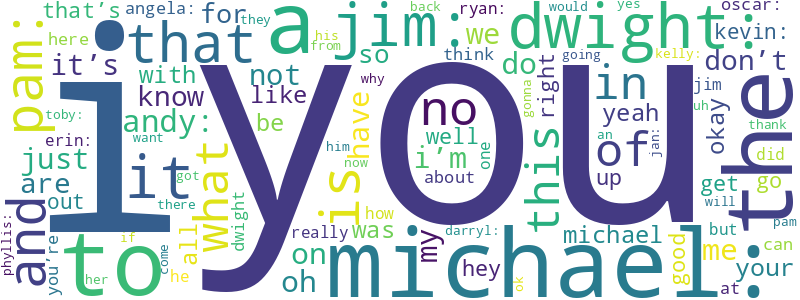

In [ ]:
all_words = list(tokenizer.word_index.keys())
all_words_freq = tokenizer.word_counts
df_all_words_freq = pd.Series(dict(all_words_freq)).sort_values(ascending=False)

wordcloud = WordCloud(width=800, height=300, background_color="white", max_words=100, contour_width=3, contour_color='steelblue').generate_from_frequencies(df_all_words_freq.to_dict())
wordcloud.to_image()

## Input-Output Mapping

*   Sequence Generation: It breaks down sentences into incremental n-grams to create training samples.
*   It transforms raw text into a "context vs. next-word" format for predictive modeling.


*   It applies pre-padding to ensure all sequences have a uniform length of 27.
 *   It splits the processed data into features ($X$) (all words except the last) and labels ($y$) (the target word to be predicted).




In [ ]:
max_sequence_len = 27

def make_sequences(lines_list):
    input_seqs = []
    for line in lines_list:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_seqs.append(n_gram_sequence)

    if not input_seqs:
        return np.array([]), np.array([])

    padded = np.array(pad_sequences(input_seqs, maxlen=max_sequence_len, padding='pre'))
    return padded[:, :-1], padded[:, -1]

## Transformation

*   Converts both sets from text lines into numerical sequences ($X$) and targets ($y$) using the previously defined function


In [ ]:
X_train, y_train = make_sequences(train_lines)
X_test, y_test = make_sequences(test_lines)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (283488, 26)
Test set size: (71041, 26)


## Perplexity Metric Definition

*   Implements Perplexity, a standard measure for evaluating how well a probability model predicts a sample.


In [ ]:
def perplexity(y_true, y_pred):
    cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    return K.exp(K.mean(cross_entropy))

## Training Optimization: Early Stopping

*   Tracks the val_loss to ensure the model's performance is measured on unseen data.



In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## LSTM Model Architecture

*   Uses the Adam optimizer
*   One Embedding and two LSTM layers with 256 and 128 units to learn complex, long-term dependencies in the text.



In [ ]:
opt = Adam(learning_rate=0.0005)

model = Sequential([
    Embedding(total_words, 150, input_length=max_sequence_len-1),
    LSTM(256, return_sequences=True),
    Dropout(0.4),
    LSTM(128),
    Dropout(0.3),
    Dense(total_words, activation='softmax')
], name="Triple_LSTM_v1_256-128")

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy', perplexity])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "Triple_LSTM_v1_256-128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 1771s 398ms/step - accuracy: 0.0401 - loss: 6.8442 - perplexity: 1430.4041 - val_accuracy: 0.0703 - val_loss: 6.2829 - val_perplexity: 588.4821
Epoch 2/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 1746s 394ms/step - accuracy: 0.0778 - loss: 6.1427 - perplexity: 491.9396 - val_accuracy: 0.0941 - val_loss: 6.0744 - val_perplexity: 481.1217
Epoch 3/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 1738s 389ms/step - accuracy: 0.0982 - loss: 5.8885 - perplexity: 381.7120 - val_accuracy: 0.1073 - val_loss: 5.9713 - val_perplexity: 432.1133
Epoch 4/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 1740s 384ms/step - accuracy: 0.1113 - loss: 5.7028 - perplexity: 317.1157 - val_accuracy: 0.1158 - val_loss: 5.9209 - val_perplexity: 408.8801
Epoch 5/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 1700s 383ms/step - accuracy: 0.1176 - loss: 5.5725 - perplexity: 278.5729 - val_accuracy: 0.1197 - val_loss: 5.8852 - val_perplexity: 393.5283
Epoch 6/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 1725s 389ms/step - accuracy: 0.1

In [ ]:
#saving for later - comparing
word_model = model
word_model_history = history

In [ ]:
max_sequence_len = 27

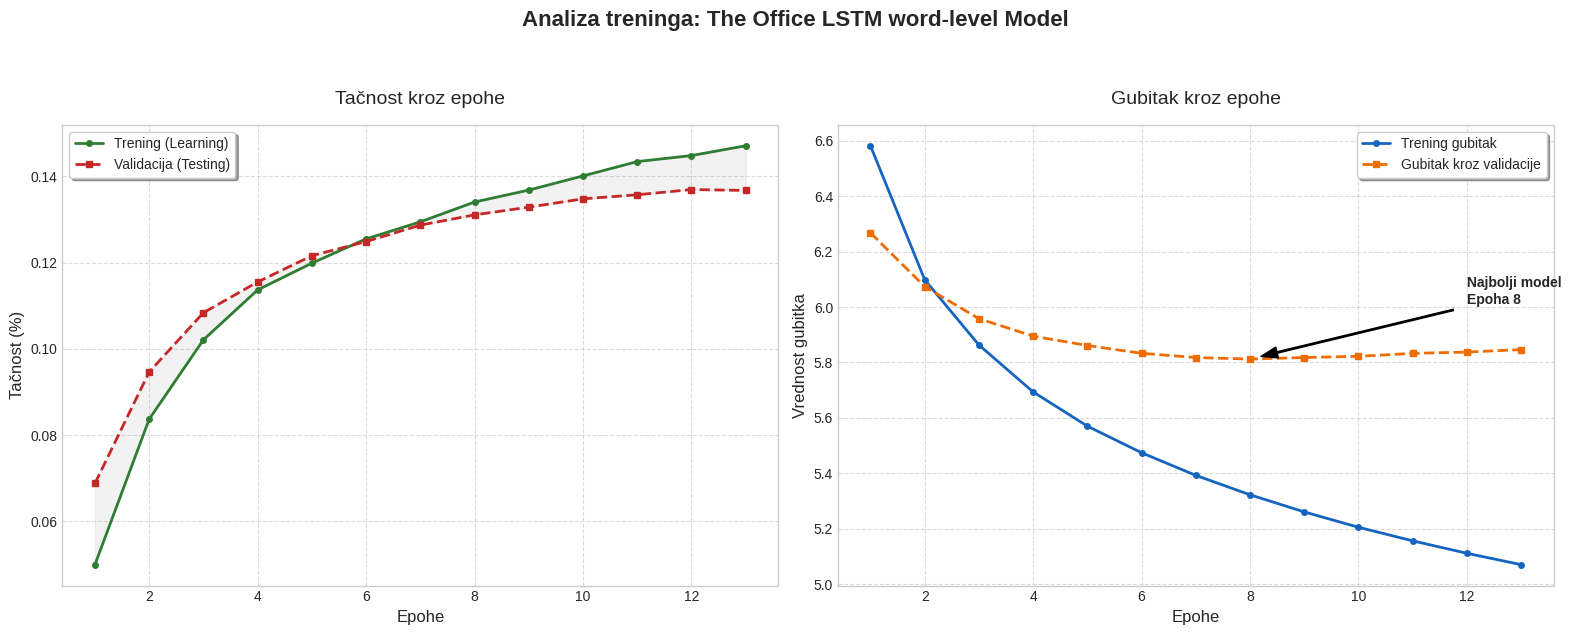

In [ ]:
def prikazi_rezultate(history):
    plt.style.use('seaborn-v0_8-whitegrid')

    h = history.history if hasattr(history, 'history') else history
    acc = h['accuracy']
    val_acc = h['val_accuracy']
    loss = h['loss']
    val_loss = h['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Analiza treninga: The Office LSTM word-level Model', fontsize=16, fontweight='bold', y=1.05)

    ax1.plot(epochs, acc, 'o-', color='#2E7D32', label='Trening (Learning)', linewidth=2, markersize=4)
    ax1.plot(epochs, val_acc, 's--', color='#C62828', label='Validacija (Testing)', linewidth=2, markersize=4)
    ax1.fill_between(epochs, acc, val_acc, color='gray', alpha=0.1)
    ax1.set_title('Tačnost kroz epohe', fontsize=14, pad=15)
    ax1.set_xlabel('Epohe', fontsize=12)
    ax1.set_ylabel('Tačnost (%)', fontsize=12)
    ax1.legend(frameon=True, shadow=True)
    ax1.grid(True, linestyle='--', alpha=0.7)

    ax2.plot(epochs, loss, 'o-', color='#1565C0', label='Trening gubitak', linewidth=2, markersize=4)
    ax2.plot(epochs, val_loss, 's--', color='#EF6C00', label='Gubitak kroz validacije', linewidth=2, markersize=4)

    best_epoch = np.argmin(val_loss)
    ax2.annotate(f'Najbolji model\nEpoha {best_epoch+1}',
                 xy=(best_epoch+1, val_loss[best_epoch]),
                 xytext=(best_epoch+5, val_loss[best_epoch]+0.2),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                 fontsize=10, fontweight='bold')

    ax2.set_title('Gubitak kroz epohe', fontsize=14, pad=15)
    ax2.set_xlabel('Epohe', fontsize=12)
    ax2.set_ylabel('Vrednost gubitka', fontsize=12)
    ax2.legend(frameon=True, shadow=True)
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

prikazi_rezultate(h_objekt)

In [ ]:
def generate_text_with_temp(seed_text, next_words, model, max_seq_len, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]
        predictions = np.asarray(predictions).astype('float64')

        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        predicted_index = np.random.choice(len(predictions), p=predictions)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        if not output_word: break
        seed_text += " " + output_word
    return seed_text

In [ ]:
def generate_scene(characters, num_of_lines=4, temperature = 0.5):
    scene = ""
    # Starting with the first character in list
    current_character = characters[0]
    seed_text = current_character + ":"

    print(f"--- GENERATED SCENE ({len(characters)} characters) --- \n")

    for i in range(num_of_lines):
        # Generating line for current character (ex. 10-12 words)
        line_with_name = generate_text_with_temp(seed_text, 12, model, max_sequence_len, temperature)

        # Filtering only line text (without seed)
        only_line = line_with_name[len(seed_text):].strip()

        # Adding the last dialog line to scene
        dialog_line = f"{current_character}: {only_line}"
        scene += dialog_line + "\n"
        print(dialog_line)

        # Choosing the next character (cycle)
        next_character = characters[(i + 1) % len(characters)]

        # New seed contains last few words from the last line
        # + name of the new character
        last_words = " ".join(only_line.split()[-3:])
        seed_tekst = last_words + " " + next_character + ":"
        current_character = next_character

In [ ]:
seed = "DWIGHT:Yesterday, I "

print("--- Konzervativni Dwight  ---")
print(generate_text_with_temp(seed, 16, model, max_sequence_len, temperature=0.2))

print("\n--- Normalni Dwight  ---")
print(generate_text_with_temp(seed, 16, model, max_sequence_len, temperature=0.5))

print("\n--- Ludi Dwight  ---")
print(generate_text_with_temp(seed, 16, model, max_sequence_len, temperature=1.0))

--- Konzervativni Dwight  ---
DWIGHT:Yesterday, I  think i don’t know what i am going to be a little bit you and i

--- Normalni Dwight  ---
DWIGHT:Yesterday, I  got it so what happened to the kitchen will be there and the dreams is a

--- Ludi Dwight  ---
DWIGHT:Yesterday, I  can let me come over i have these heads on us red belts went in a


In [ ]:
generate_scene(["MICHAEL", "DWIGHT", "JIM"], num_of_lines=5, temperature=0.4)

In [ ]:
print(generate_text_with_temp("MICHAEL: I am going to", 12, model, max_sequence_len, temperature=0.6))

MICHAEL: I am going to do that you know what i don’t get it to about the


In [ ]:
generate_scene(["MICHAEL", "JIM", "DWIGHT"], num_of_lines=6, temperature=0.5)

In [ ]:
print(model.name)

In [ ]:
print(generate_text_with_temp("MICHAEL: Birthday", 15, model, max_sequence_len, temperature=0.5))
print(generate_text_with_temp("JIM: (looks at camera) Dwight is", 12, model, max_sequence_len, temperature=0.6))
print(generate_text_with_temp("DWIGHT: Identity theft is not", 12, model, max_sequence_len, temperature=0.5))

MICHAEL: Birthday it’s not a little idea i took it to the hospital and you were a
JIM: (looks at camera) Dwight is fun with it you know what i don’t know it’s a big
DWIGHT: Identity theft is not a party in the office and looking at the office and i


In [ ]:
import pickle

model.save('Office_32k_Triple_LSTM.keras')

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

print("Gotovo! Sada je sve sačuvano bez grešaka.")
print("Fajlovi: lstm_3sloja_30k.keras i tokenizer.pickle")

In [ ]:
print(generate_text_with_temp("Jim: Michael", 15, model, max_sequence_len, temperature=0.2))

Jim: Michael i don’t know what you know what i don’t know what you don’t know what


In [ ]:
print(generate_text_with_temp("Jim: Michael ", 15, model, max_sequence_len, temperature=0.6))

Jim: Michael  i think i was an nice problem right to the hospital i want to go


In [ ]:
print(generate_text_with_temp("Jim: Michael ", 15, model, max_sequence_len, temperature=1.0))

Jim: Michael  please… i did here give there a joke dwight utter day three dream these plan


In [ ]:
print(generate_text_with_temp("Michael: ", 12, model, max_sequence_len, temperature=0.2))

Michael:  i don’t know what i am not going to be a little


In [ ]:
print(generate_text_with_temp("Michael: ", 12, model, max_sequence_len, temperature=0.6))

Michael:  jim goes to the phone oh god oh yeah that’s a big


In [ ]:
print(generate_text_with_temp("Michael: ", 12, model, max_sequence_len, temperature=1.0))

Michael:  it’s crazy gives her when i ever do that just works right


# **4. Character-level LSTM line generation model**

In [ ]:
formatted_lines[:10]

['MICHAEL:  All right Jim. Your quarterlies look very good. How are things at the library?',
 'JIM:  Oh, I told you. I couldn’t close it. So…',
 'MICHAEL:  So you’ve come to the master for guidance? Is this what you’re saying, grasshopper?',
 'JIM:  Actually, you called me in here, but yeah.',
 'MICHAEL:  All right. Well, let me show you how it’s done.  ',
 'PAM:  Well. I don’t know.',
 'MICHAEL:  If you think she’s cute now, you should have seen her a couple of years ago. [growls]',
 'MICHAEL:  Any messages?',
 'PAM:  Uh, yeah. Just a fax.',
 'MICHAEL:  Oh! Pam, this is from Corporate. How many times have I told you? There’s a special filing cabinet for things from corporate.']

## Creating and preprocessing the corpus
Turning all lines lower-case and then making a corpus with all the lines. Leaving only letters, spaces and some punctuation marks in the corpus.

In [ ]:
corpus = " ".join(formatted_lines).lower()
corpus = re.sub(r"[^a-z :,.?!]", "", corpus)
print(corpus[:120])

michael:  all right jim. your quarterlies look very good. how are things at the library? jim:  oh, i told you. i couldnt


In [ ]:
# Creating char vocabulary
chars = sorted(list(set(corpus)))
char_to_index = {c: i for i, c in enumerate(chars)}
index_to_char = {i: c for i, c in enumerate(chars)}

In [ ]:
vocab_size = len(chars)
print(f"Number of unique characters: {vocab_size}")

Number of unique characters: 32


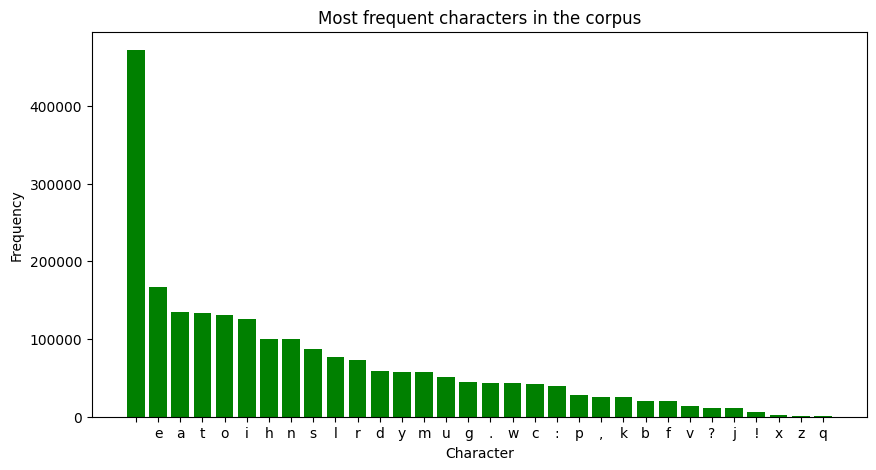

In [ ]:
char_counts = Counter(corpus)

df_chars = (
    pd.DataFrame(char_counts.items(), columns=["character", "count"])
    .sort_values("count", ascending=False)
)

plt.figure(figsize=(10, 5))
plt.bar(df_chars["character"], df_chars["count"], color="green" )
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.title("Most frequent characters in the corpus")
plt.show()

We use the previously defined train and test sets to generate the train corpus and test corpus

In [ ]:
train_corpus = " ".join(train_lines).lower()
train_corpus = re.sub(r"[^a-z :,.?!]", "", train_corpus)
print(train_corpus[:120])

val_corpus = " ".join(test_lines).lower()
val_corpus = re.sub(r"[^a-z :,.?!]", "", val_corpus)
print(val_corpus[:120])

erin:  how is everything? hows your car?   dwight:  schrute. mister schrute.  jim:  what is yankee swap? michael:  oh, p
angela:  thats why youre not in charge meredith. kelly:  youd look like an angel. im seriously going to cry. toby:  hey,


## Input-Output Mapping
* Preparing the dataset using a sliding window technique
* Slicing the text into sequences of a fixed length (max_sequence_len) which serve as inputs, while the single character immediately following each sequence is stored as the target (output) for the model to predict
*   The step parameter determines the stride between these windows to control the overlap and total number of training samples


In [ ]:
def make_sequences(text, char_to_index, max_sequence_len, step):
    input_sequences = []
    next_chars = []

    for i in range(0, len(text) - max_sequence_len, step):
        input_seq = [char_to_index[c] for c in text[i:i+max_sequence_len]]
        input_sequences.append(input_seq)
        next_chars.append(char_to_index[text[i + max_sequence_len]])

    return np.array(input_sequences, dtype=np.int32), np.array(next_chars, dtype=np.int32)

In [ ]:
max_sequence_len = 30
step = 2

X_train, y_train = make_sequences(
    train_corpus, char_to_index, max_sequence_len, step
)

X_val, y_val = make_sequences(
    val_corpus, char_to_index, max_sequence_len, step
)

In [ ]:
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)
print("X[0]:", X_train[0])
print("y[0]:", y_train[0])

X shape: (882485, 30)
y shape: (882485,)
X[0]: [10 23 14 19  4  0  0 13 20 28  0 14 24  0 10 27 10 23 30 25 13 14 19 12
  5  0 13 20 28 24]
y[0]: 0


## LSTM Model Architecture

*   Uses the Adam optimizer
*   One Embedding and two LSTM layers with 128 and 64 units to learn complex, long-term dependencies in the text.

In [ ]:
embedding_dim = 50

lstm_units_1 = 128
lstm_units_2 = 64

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(lstm_units_1, return_sequences=True),
    Dropout(0.2),
    LSTM(lstm_units_2),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [ ]:
batch_size = 128
epochs = 15

history_char = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/15
6895/6895 ━━━━━━━━━━━━━━━━━━━━ 1027s 149ms/step - accuracy: 0.3928 - loss: 2.1104 - val_accuracy: 0.5416 - val_loss: 1.5334
Epoch 2/15
6895/6895 ━━━━━━━━━━━━━━━━━━━━ 1027s 149ms/step - accuracy: 0.5291 - loss: 1.5911 - val_accuracy: 0.5692 - val_loss: 1.4231
Epoch 3/15
6895/6895 ━━━━━━━━━━━━━━━━━━━━ 1023s 148ms/step - accuracy: 0.5505 - loss: 1.5027 - val_accuracy: 0.5835 - val_loss: 1.3735
Epoch 4/15
6895/6895 ━━━━━━━━━━━━━━━━━━━━ 1034s 150ms/step - accuracy: 0.5635 - loss: 1.4584 - val_accuracy: 0.5911 - val_loss: 1.3444
Epoch 5/15
6895/6895 ━━━━━━━━━━━━━━━━━━━━ 1037s 150ms/step - accuracy: 0.5701 - loss: 1.4283 - val_accuracy: 0.5970 - val_loss: 1.3265
Epoch 6/15
6895/6895 ━━━━━━━━━━━━━━━━━━━━ 1031s 149ms/step - accuracy: 0.5751 - loss: 1.4100 - val_accuracy: 0.5987 - val_loss: 1.3137
Epoch 7/15
6895/6895 ━━━━━━━━━━━━━━━━━━━━ 1049s 151ms/step - accuracy: 0.5797 - loss: 1.3942 - val_accuracy: 0.6021 - val_loss: 1.3016
Epoch 8/15
6895/6895 ━━━━━━━━━━━━━━━━━━━━ 1048s 152ms/s

In [ ]:
#saving for later - comparing
char_model = model
char_model_history = history

The character-level LSTM model achieved a validation accuracy of 60.9% and a validation loss of 1.29. The results indicate that the model successfully learns character-level patterns and dialogue structure, while maintaining good generalization performance.

*   function that genaretes a single line using seed text and our character-level model for prediction of next characters:


In [ ]:
def sample(preds, temperature=1.0):
    """
    Taking model prediction and choosing the next character
    """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

In [ ]:
def generate_single_line(model, seed_text, char_to_index, index_to_char, length=200, temperature=1.0):
    """
    Generating chars starting from seed text
    and stopping when it finds the next ":" that is not in the seed.
    Then deletes everything after the last space.
    """
    generated = seed_text
    seed_len = len(seed_text)

    for _ in range(length):
        # Turn last max_sequence_len chars to indexes
        input_seq = [char_to_index[c] for c in generated[-max_sequence_len:]]
        input_seq = np.array(input_seq).reshape(1, -1)

        # Predicting next char
        preds = model.predict(input_seq, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = index_to_char[next_index]

        # if the next char is : stop generating (cause that means we are on the next Character lines)
        if next_char == ':' and len(generated) > seed_len:
            # Cleaning everything until the last space (probably the next Chatacter's name)
            last_space = generated.rfind(' ')
            if last_space != -1:
                generated = generated[:last_space]
            break

        # Adding char to full string
        generated += next_char

    return generated

Depending on temperature we can change the way our characters speaks.

*   lower temperature (0.3-0.6) makes our lines conservative, repetitive, grammatically stable
*   mid temperature (0.7-09) makes coherent but diverse dialogue generation
*   high temperature (1-1.3) gives us creative but unstable and noisy outputs




In [ ]:
seed = "michael: "
line = generate_single_line(model, seed, char_to_index, index_to_char, length=200, temperature=0.4)
print(line)

michael:  i have a crask


In [ ]:
seed = "michael: "
line = generate_single_line(model, seed, char_to_index, index_to_char, length=200, temperature=0.7)
print(line)

michael:  i want the sales with like the office thank you.   


In [ ]:
seed = "michael: "
line = generate_single_line(model, seed, char_to_index, index_to_char, length=200, temperature=1)
print(line)

michael:  oh now?


In [ ]:
seed = "jim: "
line = generate_single_line(model, seed, char_to_index, index_to_char, length=200, temperature=0.7)
print(line)

jim:  well i did the team is got to bothing with me.


In [ ]:
seed = "dwight: "
line = generate_single_line(model, seed, char_to_index, index_to_char, length=200, temperature=0.7)
print(line)

dwight:  i dont know what happened with the one and of the care.  


In [ ]:
seed = "pam: "
line = generate_single_line(model, seed, char_to_index, index_to_char, length=200, temperature=0.7)
print(line)

pam:  dont you get it and got the back a lious and


In [ ]:
seed = "toby: "
line = generate_single_line(model, seed, char_to_index, index_to_char, length=200, temperature=0.7)
print(line)

toby:  so from you store and so face.  


In [ ]:
seed = "oscar: jim,"
line = generate_single_line(model, seed, char_to_index, index_to_char, length=200, temperature=0.6)
print(line)

oscar: jim, and i am really say up a really thinking and its not droar the corporate to the weeking that i are mean in the talking of croen, so alright one and scranton.  




*   trying to generate "thats what she said"



In [ ]:
seed = "thats what she "
line = generate_single_line(model, seed, char_to_index, index_to_char, length=200, temperature=0.5)
print(line)

thats what she does this an old down.  


# **5. Comparing**

In [ ]:
#THIS PART WILL BE DELETED:
import pickle
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from google.colab import drive
import os

drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/Colab_Models/word_level_LSTM.keras'
tokenizer_path = '/content/drive/MyDrive/Colab_Models/tokenizer.pkl'

with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

word_model = load_model(model_path, custom_objects={'perplexity': perplexity})

char_model_path = '/content/drive/MyDrive/Colab_Models/CharFinal.keras'
char_model = load_model(char_model_path)

print("Sve je uspešno učitano! Modeli su spremni za rad.")

Mounted at /content/drive
Sve je uspešno učitano! Modeli su spremni za rad.


In [ ]:
#THIS PART WILL BE DELETED:
drive.mount('/content/drive')
word_model_history_path = '/content/drive/MyDrive/Colab_Models/training_history.json'
char_model_history_path = '/content/drive/MyDrive/Colab_Models/CharFinal_history.json'

with open(word_model_history_path, 'r') as f:
    word_model_history = json.load(f)

with open(char_model_history_path, 'r') as f:
    char_model_history = json.load(f)

print("Istorija epoha je uspešno učitana!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Istorija epoha je uspešno učitana!


Comparing our two models using the same seeds and temperatures.

In [ ]:
seed = "michael: "
print("CHAR-LEVEL: " + generate_single_line(char_model, seed, char_to_index, index_to_char, length=200, temperature=0.6))
print("WORD-LEVEL: " + generate_text_with_temp(seed, 15, word_model, max_sequence_len, temperature=0.6))

CHAR-LEVEL: michael:  well, thats not one.
WORD-LEVEL: michael:  oh it’s a little bit toby i have to let you know that i would


In [ ]:
seed = "jim: "
print("CHAR-LEVEL: " + generate_single_line(char_model, seed, char_to_index, index_to_char, length=200, temperature=0.5))
print("WORD-LEVEL: " + generate_text_with_temp(seed, 12, word_model, max_sequence_len, temperature=0.5))

CHAR-LEVEL: jim:  hey, come on, for you.  
WORD-LEVEL: jim:  i don’t know if is a really good idea and i just


In [ ]:
seed = "oscar: "
print("CHAR-LEVEL: " + generate_single_line(char_model, seed, char_to_index, index_to_char, length=200, temperature=0.9))
print("WORD-LEVEL: " + generate_text_with_temp(seed, 15, word_model, max_sequence_len, temperature=0.9))

CHAR-LEVEL: oscar:  no can you fight?
WORD-LEVEL: oscar:  hey and do we want to lie it to stop bernard talking to me to


In [ ]:
seed = "michael: happy"
print("CHAR-LEVEL: " + generate_single_line(char_model, seed, char_to_index, index_to_char, length=200, temperature=0.6))
print("WORD-LEVEL: " + generate_text_with_temp(seed, 15, word_model, max_sequence_len, temperature=0.6))

CHAR-LEVEL: michael: happy in least money. i shork of a lot a little tent eating all a rescound of this crossion pam think of the back at it.  
WORD-LEVEL: michael: happy and the wooden are out of the promotion you are going to be here for


In [ ]:
seed = "thats what she"
print("CHAR-LEVEL: " + generate_single_line(char_model, seed, char_to_index, index_to_char, length=200, temperature=0.4))
print("WORD-LEVEL: " + generate_text_with_temp(seed, 15, word_model, max_sequence_len, temperature=0.4))

CHAR-LEVEL: thats what she say it.  
WORD-LEVEL: thats what she was a very good idea i don’t know what you have a little name of


In [ ]:
seed = "thats what she"
print("CHAR-LEVEL: " + generate_single_line(char_model, seed, char_to_index, index_to_char, length=200, temperature=1))
print("WORD-LEVEL: " + generate_text_with_temp(seed, 15, word_model, max_sequence_len, temperature=1))

CHAR-LEVEL: thats what she need connandly. my firtin, and thats but hes indegilf
WORD-LEVEL: thats what she water lost the office corporate do really would’ve will just leave her in a grill


With higher temperatures, both models exhibit increased "creativity"
* the word-level model tends to generate sentences that lack logical sense
* the char-level model begins to invent non-existent words

Overall, both models demonstrate a solid ability to generate recognizable and often grammatically functional sentences.

In [ ]:
def show_results(history):
    plt.style.use('seaborn-v0_8-whitegrid')

    h = history.history if hasattr(history, 'history') else history
    acc = h['accuracy']
    val_acc = h['val_accuracy']
    loss = h['loss']
    val_loss = h['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Training Analysis: The Office LSTM model', fontsize=16, fontweight='bold', y=1.05)

    ax1.plot(epochs, acc, 'o-', color='#2E7D32', label='Training (Learning)', linewidth=2, markersize=4)
    ax1.plot(epochs, val_acc, 's--', color='#C62828', label='Validation (Testing)', linewidth=2, markersize=4)
    ax1.fill_between(epochs, acc, val_acc, color='gray', alpha=0.1)
    ax1.set_title('Accuracy Evolution', fontsize=14, pad=15)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.legend(frameon=True, shadow=True)
    ax1.grid(True, linestyle='--', alpha=0.7)

    ax2.plot(epochs, loss, 'o-', color='#1565C0', label='Training loss', linewidth=2, markersize=4)
    ax2.plot(epochs, val_loss, 's--', color='#EF6C00', label='Validation Loss', linewidth=2, markersize=4)

    best_epoch = np.argmin(val_loss)
    ax2.annotate(f'The best model\nEpoch {best_epoch+1}',
                 xy=(best_epoch+1, val_loss[best_epoch]),
                 xytext=(best_epoch+5, val_loss[best_epoch]+0.2),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                 fontsize=10, fontweight='bold')

    ax2.set_title('Loss Evolution', fontsize=14, pad=15)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(frameon=True, shadow=True)
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

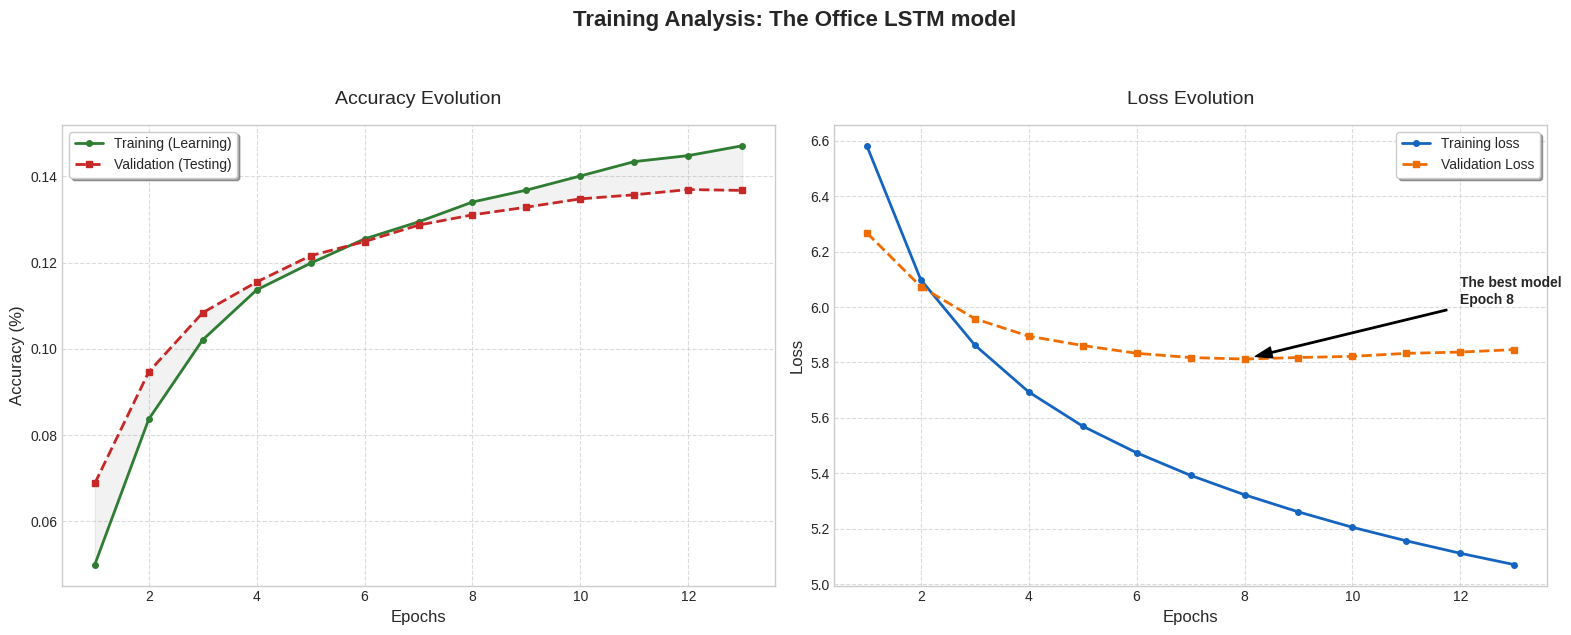

In [ ]:
show_results(word_model_history)

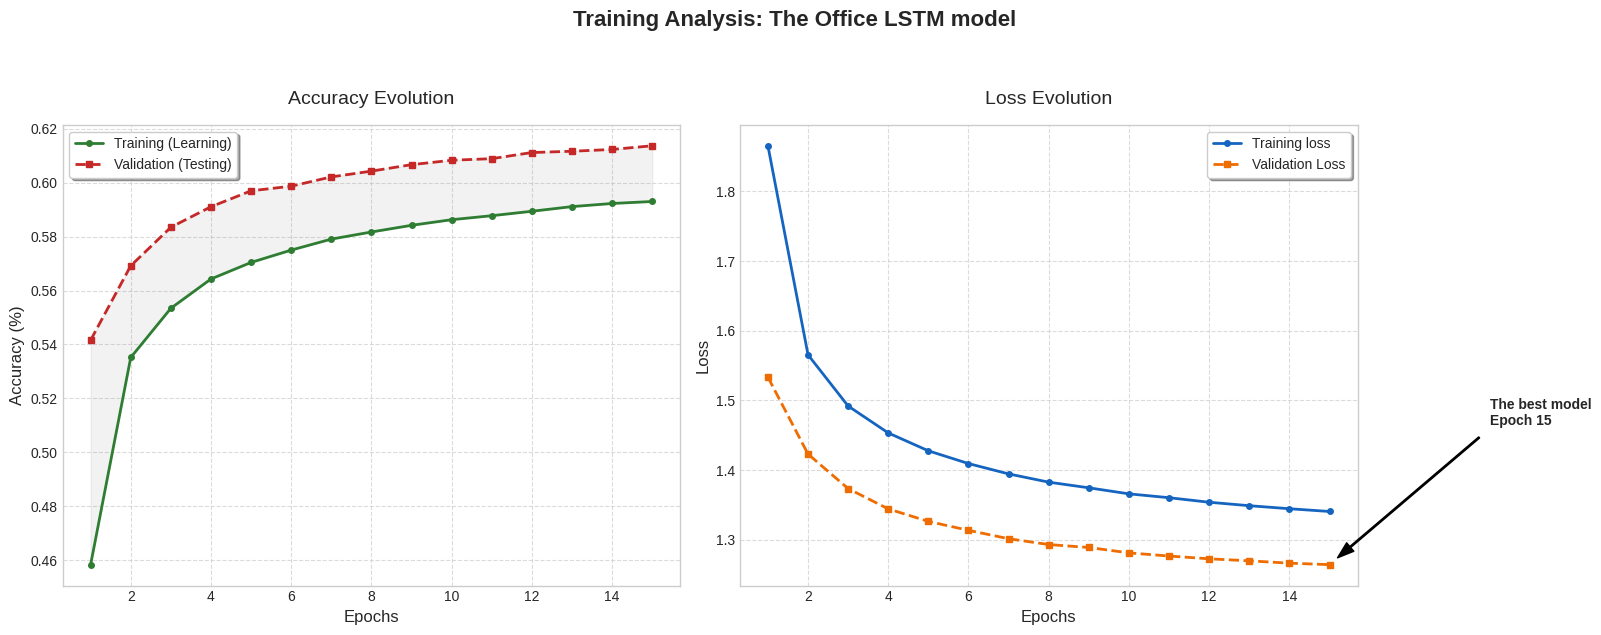

In [ ]:
show_results(char_model_history)